# Northwind Trades ® - Enhancing Product Recommendations and Warehouse Efficiency through Data-Driven Analytics
## Part 2: Neo4j Data Loading

### Neo4j Database Overview

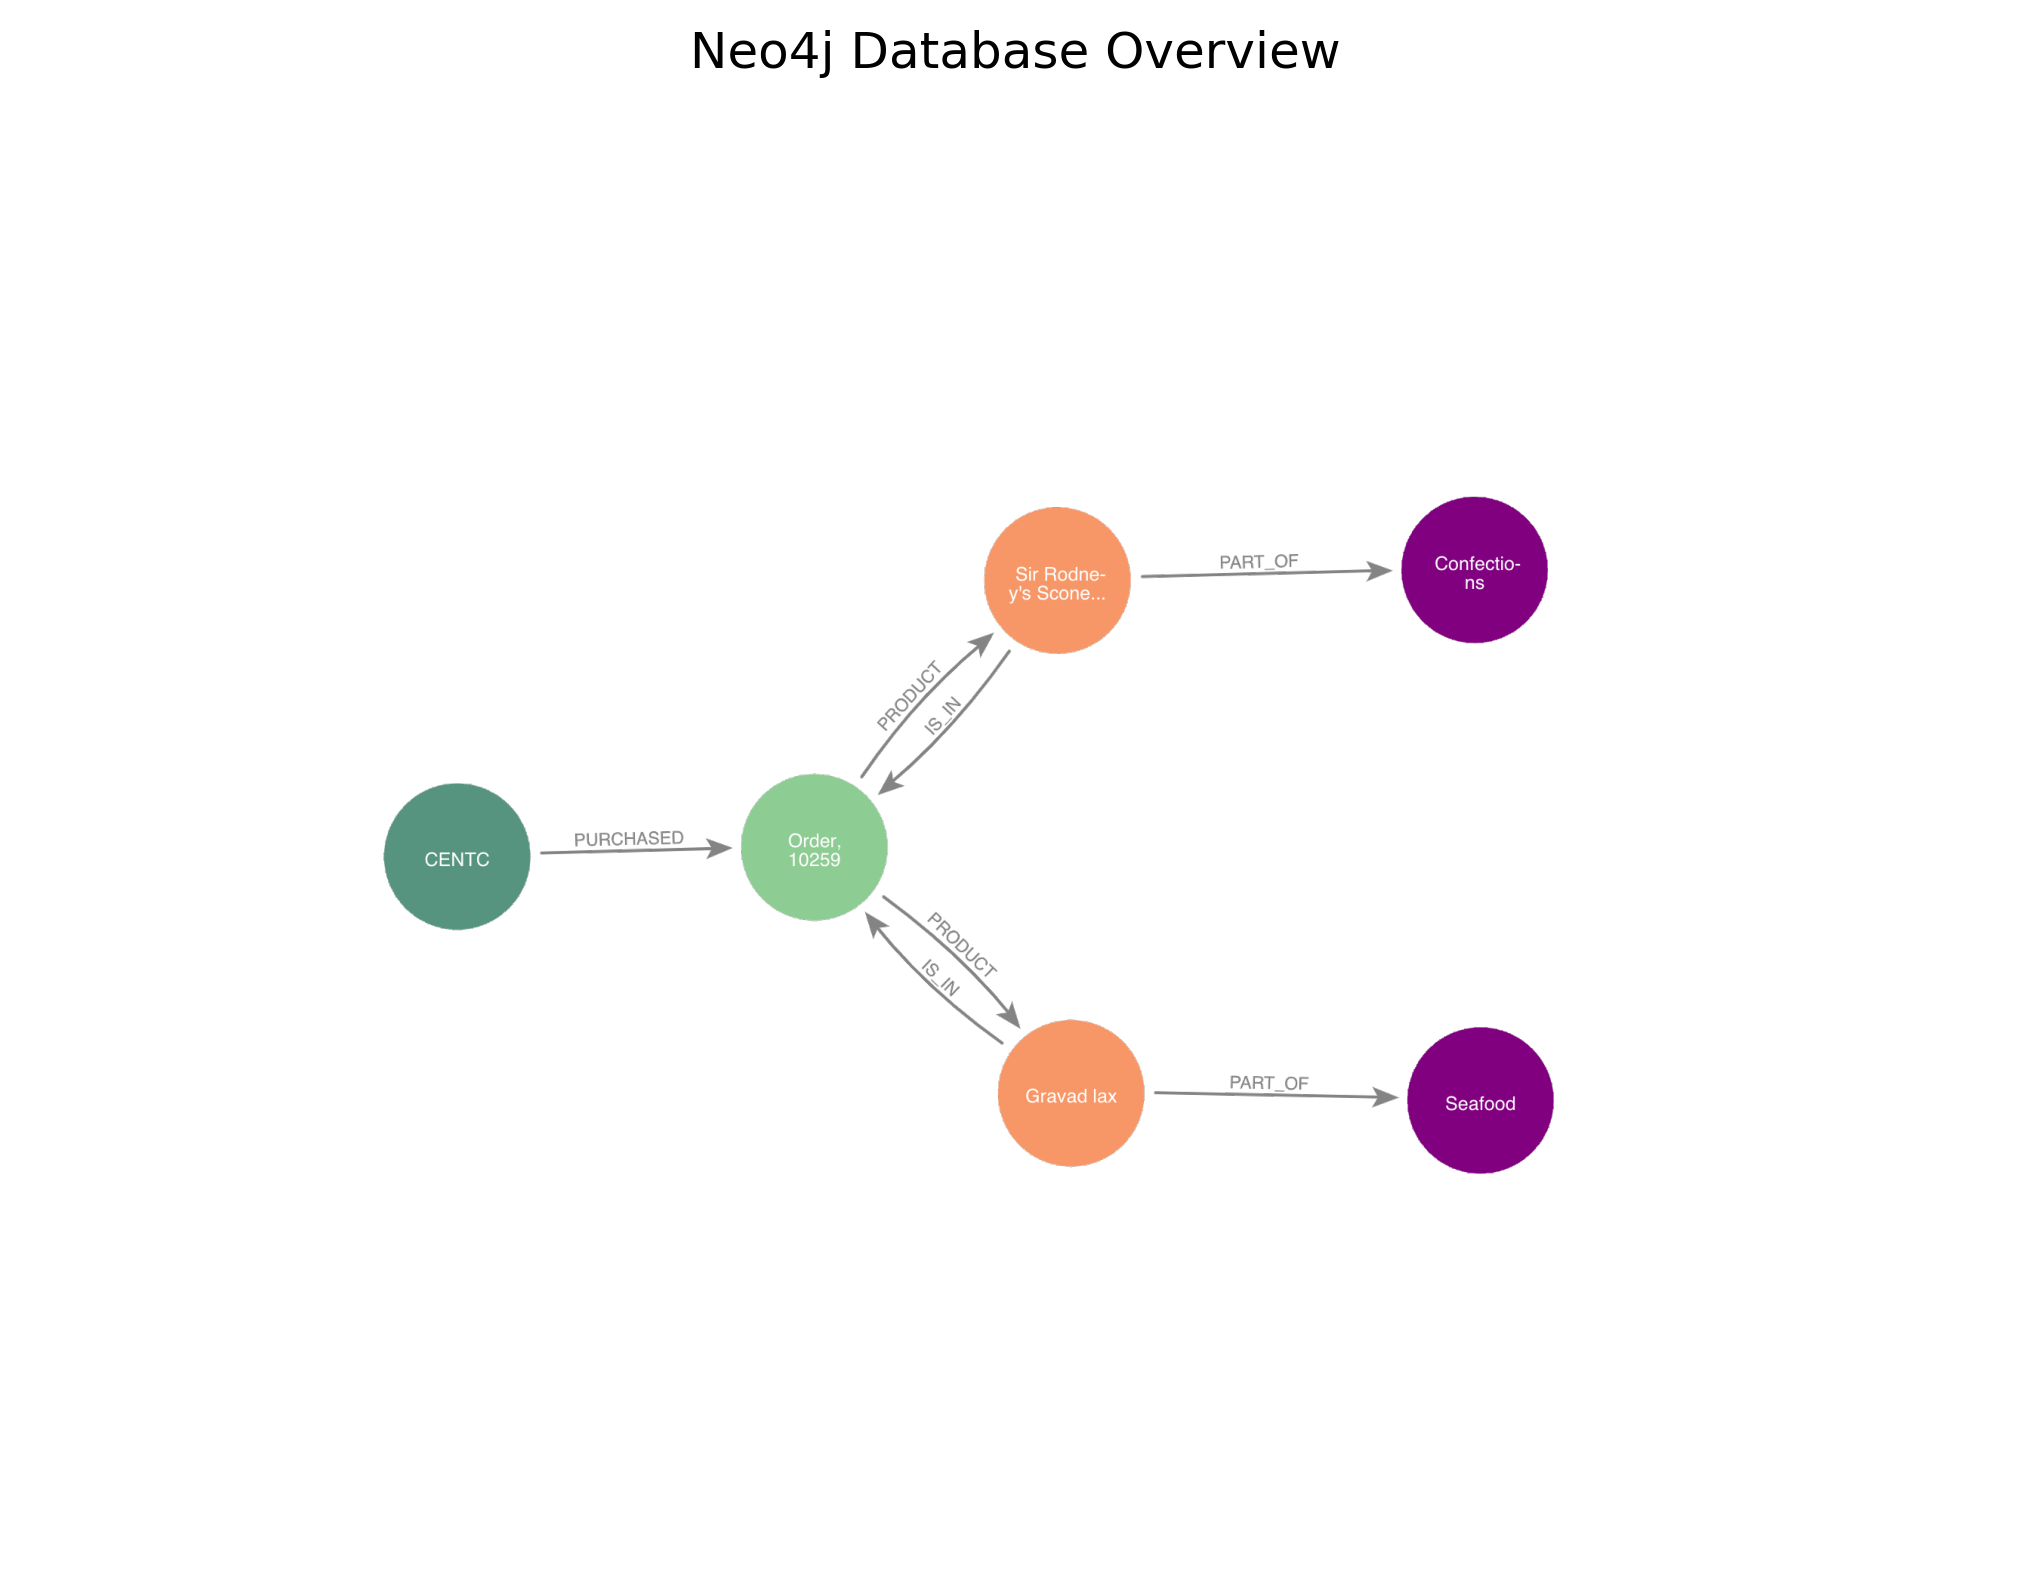

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


def show_image(image_path: str, title: str, dpi: int = 300) -> None:
    img = mpimg.imread(image_path)
    plt.figure(dpi=dpi, figsize=(img.shape[1] / dpi, img.shape[0] / dpi))
    plt.title(title)

    # Remove x and y ticks
    plt.xticks([])
    plt.yticks([])

    # Remove the axis (borders)
    plt.axis('off')

    plt.imshow(img)
    plt.show()


show_image("images/neo4j_db.png", "Neo4j Database Overview", dpi=300)

### Included Modules, Packages

In [2]:
import math
import warnings

import numpy as np
import pandas as pd
import psycopg2

warnings.filterwarnings("ignore", category=UserWarning, message="pandas only supports SQLAlchemy connectable")

### Wipe out existing Neo4j Database

In [3]:
import getpass
import platform
from neo4j import Session, Driver, GraphDatabase


def generate_neo4j_local_driver() -> Driver:
    if platform.system() == "Darwin" and getpass.getuser() == "honghu":
        return GraphDatabase.driver(uri="bolt://localhost:7689", auth=("neo4j", "ucb_mids_w205"))
    else:
        return GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j", "ucb_mids_w205"))


def generate_neo4j_local_session(driver: Driver, database: str = "neo4j") -> Session:
    return driver.session(database=database)


def my_neo4j_wipe_out_database(session, is_index: bool = False) -> None:
    """
    Wipe out the Neo4j database by deleting all nodes and relationships.

    :param session: The Neo4j session to run the queries.
    :param is_index: Whether to drop all indexes and constraints. Default is False.
    """
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    query = "match (node) delete node"
    session.run(query)

    if is_index:
        # Drop all constraints
        constraints = session.run("SHOW CONSTRAINTS")
        for record in constraints:
            session.run(f"DROP CONSTRAINT {record['name']} IF EXISTS")

        # Drop all indexes
        indexes = session.run("SHOW INDEXES")
        for record in indexes:
            session.run(f"DROP INDEX {record['name']} IF EXISTS")


driver = generate_neo4j_local_driver()
neo4j_session = generate_neo4j_local_session(driver)
my_neo4j_wipe_out_database(neo4j_session, is_index=True)

### Neo4j Supporting Functions

In [4]:
from typing import List
from psycopg2._psycopg import connection


def generate_postgres_mids_conn() -> connection:
    if platform.system() == "Darwin" and getpass.getuser() == "honghu":
        return psycopg2.connect(
            user="postgres",
            password="abc123",
            host="localhost",
            port="5433",
            database="postgres"
        )
    else:
        return psycopg2.connect(
            user="postgres",
            password="ucb",
            host="postgres",
            port="5432",
            database="postgres"
        )


def my_select_query_pandas(
        query: str, params: list = None, conn: connection = None, rollback_before_flag: bool = True,
        rollback_after_flag: bool = True
) -> pd.DataFrame:
    """
    function to run a select query and return rows in a pandas dataframe

    :param query: The SQL query to execute.
    :param params: The parameters to pass to the query. Defaults to None.
    :param conn: The database connection to use. Defaults to a generated Postgres connection.
    :param rollback_before_flag: If True, performs a rollback before executing the query. Defaults to True.
    :param rollback_after_flag: If True, performs a rollback after executing the query. Defaults to True.
    :return: A pandas DataFrame containing the query results.
    """
    if conn is None:
        with generate_postgres_mids_conn() as new_conn:
            return my_select_query_pandas(query, params, new_conn, rollback_before_flag, rollback_after_flag)

    if rollback_before_flag:
        conn.rollback()

    if params is not None:
        df = pd.read_sql_query(query, conn, params=params)
    else:
        df = pd.read_sql_query(query, conn)

    if rollback_after_flag:
        conn.rollback()

    # fix the float columns that really should be integers
    for column in df:
        if df[column].dtype == "float64":
            fraction_flag = False
            for value in df[column].values:
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True
            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    return df


def my_select_query_dict_list(query: str, params: list = None, conn: connection = None,
                              rollback_before_flag: bool = True, rollback_after_flag: bool = True) -> List[dict]:
    df = my_select_query_pandas(query=query, params=params, conn=conn, rollback_before_flag=rollback_before_flag,
                                rollback_after_flag=rollback_after_flag)
    return df.to_dict(orient='records')


def my_neo4j_exec_query(query: str, session: Session, is_reset: bool = False, **kwargs):
    """
    Execute a Neo4j query using the provided session and additional keyword arguments.

    :param query: The Cypher query to be executed.
    :param session: The Neo4j session to use for executing the query.
    :param is_reset: A flag indicating whether to reset the database before executing the query.
    :param kwargs: Additional keyword arguments to pass to the session.run() method.
    """
    if is_reset:
        my_neo4j_wipe_out_database(session)
    session.run(query, **kwargs)


def my_neo4j_run_query_pandas(query: str, session: Session, **kwargs) -> pd.DataFrame:
    """
    Run a query and return the results in a pandas DataFrame.

    :param query: The Cypher query to be executed.
    :param session: The Neo4j session to use for running the query.
    :param kwargs: Additional parameters to pass to the session.run() method.
    :return: A pandas DataFrame containing the query results.
    """
    result = session.run(query, **kwargs)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())


def my_neo4j_create_node_with_attrs(node_label: str, session: Session, **attrs) -> None:
    """
    Create a node with label Station.

    :param node_label: The name of the station.
    :param session: The Neo4j session to use for the query.
    """
    kwargs = ', '.join([f"{key}: ${key}" for key in attrs.keys()])
    query = f"""
CREATE (:{node_label} {{{kwargs}}})
    """
    my_neo4j_exec_query(query=query, session=session, is_reset=False, **attrs)


def my_neo4j_create_edge(beg_node_label: str, beg_node_id: str, end_node_id: str, session: Session,
                         end_node_label: str = None, weight: float = None, edge_name: str = "LINK",
                         is_two_way: bool = False):
    """
    Create an edge between two nodes with a specified weight.

    :param beg_node_label: beginning node label
    :param beg_node_id: The name of the starting node.
    :param end_node_label: end node label
    :param end_node_id: The name of the destination node.
    :param weight: The weight of the relationship.
    :param session: The Neo4j session to use for the query.
    :param edge_name: edge name
    :param is_two_way: is two-way relationship
    """
    kwargs = {
        "beg_node_id": beg_node_id,
        "end_node_id": end_node_id,
    }
    if end_node_label is None:
        end_node_label = beg_node_label
    weight_cypher = ""
    if weight is not None:
        kwargs["weight"] = weight
        weight_cypher = " {weight: $weight}"
    two_way_cypher = '' if params_template['is_two_way'] else '>'
    query = f"""
MATCH (from:{beg_node_label}), 
      (to:{end_node_label})
WHERE from.id = $beg_node_id and to.id = $end_node_id
CREATE (from)-[:{edge_name}{weight_cypher}]-{two_way_cypher}(to)
    """
    my_neo4j_exec_query(query=query, session=session, is_reset=False, **kwargs)


postgres_conn = generate_postgres_mids_conn()

### Load the Nodes for Customers and Verify Them

In [5]:
sql = """
select customer_id as id, company_name from customers;
"""
customers_dict = my_select_query_dict_list(query=sql, conn=postgres_conn)

for customer_dict in customers_dict:
    my_neo4j_create_node_with_attrs(node_label="Customer", session=neo4j_session, **customer_dict)

cypher_index = "CREATE INDEX customer_id FOR (c:Customer) ON (c.id);"
neo4j_session.run(cypher_index)

cypher_index = "CREATE INDEX company_name FOR (c:Customer) ON (c.company_name);"
neo4j_session.run(cypher_index)

cypher_query = """
MATCH (n:Customer) 
RETURN n.id as customer_id, n.company_name as company_name
ORDER BY n.id
"""
my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)

,customer_id,company_name
0,ALFKI,Alfreds Futterkiste
1,ANATR,Ana Trujillo Emparedados y helados
2,ANTON,Antonio Moreno Taquería
3,AROUT,Around the Horn
4,BERGS,Berglunds snabbköp
...,...,...
86,WARTH,Wartian Herkku
87,WELLI,Wellington Importadora
88,WHITC,White Clover Markets
89,WILMK,Wilman Kala


### Load the Nodes for Products and Verify Them

In [6]:
sql = """
select product_id as id, product_name from products;
"""
products_dict = my_select_query_dict_list(query=sql, conn=postgres_conn)

for product_dict in products_dict:
    my_neo4j_create_node_with_attrs(node_label="Product", session=neo4j_session, **product_dict)

cypher_index = "CREATE INDEX product_id FOR (p:Product) ON (p.id);"
neo4j_session.run(cypher_index)

cypher_index = "CREATE INDEX product_name FOR (p:Product) ON (p.product_name);"
neo4j_session.run(cypher_index)

cypher_query = """
MATCH (n:Product) 
RETURN n.id as product_id, n.product_name as product_name
ORDER BY n.id
"""
my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)

,product_id,product_name
0,1,Chai
1,2,Chang
2,3,Aniseed Syrup
3,4,Chef Anton's Cajun Seasoning
4,5,Chef Anton's Gumbo Mix
...,...,...
72,73,Röd Kaviar
73,74,Longlife Tofu
74,75,Rhönbräu Klosterbier
75,76,Lakkalikööri


### Load the Nodes for Product Categories and Verify Them

In [7]:
sql = """
select category_id as id, category_name from categories;
"""
categories_dict = my_select_query_dict_list(query=sql, conn=postgres_conn)

for category_dict in categories_dict:
    my_neo4j_create_node_with_attrs(node_label="Category", session=neo4j_session, **category_dict)

cypher_index = "CREATE INDEX category_id FOR (c:Category) ON (c.id);"
neo4j_session.run(cypher_index)

cypher_query = """
MATCH (n:Category) 
RETURN n.id as category_id, n.category_name as category_name
ORDER BY n.id
"""
my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)

,category_id,category_name
0,1,Beverages
1,2,Condiments
2,3,Confections
3,4,Dairy Products
4,5,Grains/Cereals
5,6,Meat/Poultry
6,7,Produce
7,8,Seafood


### Load the Nodes for Orders and Verify Them

In [8]:
sql = """
select order_id as id from orders;
"""
orders_dict = my_select_query_dict_list(query=sql, conn=postgres_conn)

for order_dict in orders_dict:
    my_neo4j_create_node_with_attrs(node_label="Order", session=neo4j_session, **order_dict)

cypher_index = "CREATE INDEX order_id FOR (o:Order) ON (o.id);"
neo4j_session.run(cypher_index)

cypher_query = """
MATCH (n:Order) 
RETURN n.id as order_id
ORDER BY n.id
"""
my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)

,order_id
0,10248
1,10249
2,10250
3,10251
4,10252
...,...
825,11073
826,11074
827,11075
828,11076


### Load Directed `PURCHASED` Edges between Customers and Orders

In [9]:
sql = """
select customers.customer_id as beg_node_id, order_id as end_node_id
from orders
join customers on customers.customer_id = orders.customer_id
;
"""
params_template = {
    "session": neo4j_session,
    "is_two_way": False,
    "beg_node_label": "Customer",
    "end_node_label": "Order",
    "edge_name": "PURCHASED"
}
dict_list = my_select_query_dict_list(query=sql, conn=postgres_conn)
for di in dict_list:
    params = {
        "beg_node_id": di["beg_node_id"],
        "end_node_id": di["end_node_id"]
    }
    my_neo4j_create_edge(**params_template, **params)

cypher_query = f"""
MATCH (n1:{params_template['beg_node_label']})-[r:{params_template['edge_name']}]-{'' if params_template['is_two_way'] else '>'}(n2:{params_template['end_node_label']})
RETURN n1.id as customer_id, n2.id as order_id
ORDER BY n1.id, n2.id
"""
my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)

,customer_id,order_id
0,ALFKI,10643
1,ALFKI,10692
2,ALFKI,10702
3,ALFKI,10835
4,ALFKI,10952
...,...,...
825,WOLZA,10792
826,WOLZA,10870
827,WOLZA,10906
828,WOLZA,10998


### Load Directed `PRODUCT` Edges between Orders and Products

In [10]:
sql = """
select order_id as beg_node_id, products.product_id as end_node_id
from products
join order_details on products.product_id = order_details.product_id
"""
params_template = {
    "session": neo4j_session,
    "is_two_way": False,
    "beg_node_label": "Order",
    "end_node_label": "Product",
    "edge_name": "PRODUCT"
}
dict_list = my_select_query_dict_list(query=sql, conn=postgres_conn)
for di in dict_list:
    params = {
        "beg_node_id": di["beg_node_id"],
        "end_node_id": di["end_node_id"]
    }
    my_neo4j_create_edge(**params_template, **params)

cypher_query = f"""
MATCH (n1:{params_template['beg_node_label']})-[r:{params_template['edge_name']}]-{'' if params_template['is_two_way'] else '>'}(n2:{params_template['end_node_label']})
RETURN n1.id as order_id, n2.product_name as product_name
ORDER BY n1.id, n2.id
"""
my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)

,order_id,product_name
0,10248,Queso Cabrales
1,10248,Singaporean Hokkien Fried Mee
2,10248,Mozzarella di Giovanni
3,10249,Tofu
4,10249,Manjimup Dried Apples
...,...,...
2150,11077,Wimmers gute Semmelknödel
2151,11077,Louisiana Hot Spiced Okra
2152,11077,Röd Kaviar
2153,11077,Rhönbräu Klosterbier


### Load Directed `IS_IN` Edges between Products and Orders

In [11]:
sql = """
select products.product_id as beg_node_id, order_id as end_node_id
from products
join order_details on products.product_id = order_details.product_id
"""
params_template = {
    "session": neo4j_session,
    "is_two_way": False,
    "beg_node_label": "Product",
    "end_node_label": "Order",
    "edge_name": "IS_IN"
}
dict_list = my_select_query_dict_list(query=sql, conn=postgres_conn)
for di in dict_list:
    params = {
        "beg_node_id": di["beg_node_id"],
        "end_node_id": di["end_node_id"]
    }
    my_neo4j_create_edge(**params_template, **params)

cypher_query = f"""
MATCH (n1:{params_template['beg_node_label']})-[r:{params_template['edge_name']}]-{'' if params_template['is_two_way'] else '>'}(n2:{params_template['end_node_label']})
RETURN n1.product_name as product_name, n2.id as order_id
ORDER BY n1.id, n2.id
"""
my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)

,product_name,order_id
0,Chai,10285
1,Chai,10294
2,Chai,10317
3,Chai,10348
4,Chai,10354
...,...,...
2150,Original Frankfurter grüne Soße,11000
2151,Original Frankfurter grüne Soße,11015
2152,Original Frankfurter grüne Soße,11060
2153,Original Frankfurter grüne Soße,11068


### Load Directed `PART_OF` Edges between Products and Categories

In [12]:
sql = """
select product_id as beg_node_id, categories.category_id as end_node_id
from products
join categories on products.category_id = categories.category_id
"""
params_template = {
    "session": neo4j_session,
    "is_two_way": False,
    "beg_node_label": "Product",
    "end_node_label": "Category",
    "edge_name": "PART_OF"
}
dict_list = my_select_query_dict_list(query=sql, conn=postgres_conn)
for di in dict_list:
    params = {
        "beg_node_id": di["beg_node_id"],
        "end_node_id": di["end_node_id"]
    }
    my_neo4j_create_edge(**params_template, **params)

cypher_query = f"""
MATCH (n1:{params_template['beg_node_label']})-[r:{params_template['edge_name']}]-{'' if params_template['is_two_way'] else '>'}(n2:{params_template['end_node_label']})
RETURN n1.product_name as product_name, n2.category_name as category_name
ORDER BY n1.id, n2.id
"""
my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)

,product_name,category_name
0,Chai,Beverages
1,Chang,Beverages
2,Aniseed Syrup,Condiments
3,Chef Anton's Cajun Seasoning,Condiments
4,Chef Anton's Gumbo Mix,Condiments
...,...,...
72,Röd Kaviar,Seafood
73,Longlife Tofu,Produce
74,Rhönbräu Klosterbier,Beverages
75,Lakkalikööri,Beverages
